In [28]:
# cv_analysis.ipynb

import json
import os
import sys
from pathlib import Path
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

PROJECT_ROOT = Path("..").resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data.dataloader import (
    ForgeryDataset,
    detection_collate_fn,
    get_val_transform,
)
from src.models.mask2former_v1 import Mask2FormerForgeryModel
from src.utils.config_utils import load_yaml, sanitize_model_kwargs
from src.training.train_cv import build_solution_df
from src.data.dataloader import ForgeryDataset
from src.models.kaggle_metric import score as kaggle_score

plt.style.use("ggplot")

In [29]:
# -----------------
# Constants / Paths
# -----------------

OOF_ROOT = PROJECT_ROOT / "experiments" / "oof_results"
FULL_TRAIN_ROOT = PROJECT_ROOT / "experiments" / "full_train_results"

CLS_THRESHOLD_PATH = (
    PROJECT_ROOT / "experiments" / "cls_threshold_sweep" / "cls_threshold_sweep.csv"
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CFG_PATH = PROJECT_ROOT / "config" / "base.yaml"

CLPSE_ROOT = PROJECT_ROOT / "experiments" / "cls_collapse"

SAMPLEDUMP_ROOT = PROJECT_ROOT / "experiments" / "oof_results"

### OOF CV results

In [30]:
# List what's in experiments/oof_results/
oof_items = list(OOF_ROOT.iterdir())
oof_dirs = sorted([p.name for p in oof_items if p.is_dir()])
oof_files = sorted([p.name for p in oof_items if p.is_file()])

print("OOF dirs:", oof_dirs)
if oof_files:
    print("OOF loose files:", oof_files)


OOF dirs: ['base_wgroupkfold', 'gate_pass_TRUE', 'mini_smoke']
OOF loose files: ['sanity_random_200.csv']


In [31]:
def load_run(names):
    """
    names:
      - str: dir name under OOF_ROOT OR filename under OOF_ROOT
      - list/tuple[str]: load multiple; returns dict keyed by run/filename
    """
    if isinstance(names, (list, tuple)):
        return {str(n): load_run(str(n)) for n in names}

    name = str(names)
    p = OOF_ROOT / name

    # Case A: run directory
    if p.is_dir():
        run_dir = p
        oof_csv = run_dir / "oof_predictions.csv"
        metrics_json = run_dir / "oof_metrics.json"

        oof_df = pd.read_csv(oof_csv) if oof_csv.exists() else None
        metrics = json.load(metrics_json.open()) if metrics_json.exists() else None

        fold_files = sorted(run_dir.glob("fold_*_oof.csv"))
        fold_dfs = {f.stem: pd.read_csv(f) for f in fold_files}

        return {"name": run_dir.name, "path": run_dir, "oof": oof_df, "metrics": metrics, "folds": fold_dfs}

    # Case B: loose file
    if p.is_file():
        if p.suffix.lower() == ".csv":
            return {"name": p.name, "path": p, "oof": pd.read_csv(p), "metrics": None, "folds": {}}
        if p.suffix.lower() == ".json":
            return {"name": p.name, "path": p, "oof": None, "metrics": json.load(p.open()), "folds": {}}
        raise ValueError(f"Unsupported file type: {p.suffix}")

    raise FileNotFoundError(f"Not found under OOF_ROOT: {name}")

# Use load_run(name | [names]) to load one or more CV runs or loose files from experiments/oof_results/
runs = load_run(["gate_pass_TRUE"])  # or: load_run("mini_smoke"), load_run("oof_predictions.csv")

print("Loaded:")
if isinstance(runs, dict) and "name" not in runs:
    for k, v in runs.items():
        print(f" - {v['name']} ({v['path']})")
else:
    print(f" - {runs['name']} ({runs['path']})")



Loaded:
 - gate_pass_TRUE (C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results\gate_pass_TRUE)


=== Loaded runs ===

gate_pass_TRUE
  Mean CV   : 0.42342663216943294
  OOF score : 0.42343347872937315
  Folds     : [0.45886442641946695, 0.3413575555143108, 0.47005791457452123]


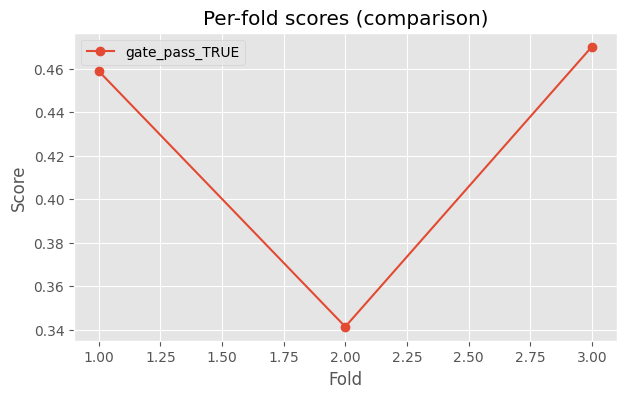

In [33]:
def show_run_metrics(names):
    """
    Pass a run dir name (str) or list of names to compare.
    """
    runs = load_run(names)
    if isinstance(runs, dict) and "name" not in runs:
        items = list(runs.values())
    else:
        items = [runs]

    # Clean summary header
    print("=== Loaded runs ===")
    for r in items:
        m = r["metrics"] or {}
        mean_cv = m.get("mean_cv", None)
        oof_score = m.get("oof_score", None)
        fold_scores = m.get("fold_scores", None)

        print(f"\n{r['name']}")
        print(f"  Mean CV   : {mean_cv}")
        print(f"  OOF score : {oof_score}")
        if fold_scores is not None:
            print(f"  Folds     : {fold_scores}")

    # Comparison plot (only for runs that have fold_scores)
    plot_items = [(r["name"], (r["metrics"] or {}).get("fold_scores")) for r in items]
    plot_items = [(n, fs) for (n, fs) in plot_items if fs is not None]

    if plot_items:
        plt.figure(figsize=(7, 4))
        for name, fs in plot_items:
            plt.plot(range(1, len(fs) + 1), fs, marker="o", label=name)
        plt.xlabel("Fold")
        plt.ylabel("Score")
        plt.title("Per-fold scores (comparison)")
        plt.legend()
        plt.show()

    return runs

# Single run
_ = show_run_metrics("gate_pass_TRUE")

# Compare multiple runs
# _ = show_run_metrics(["mini_smoke", "some_other_run"])



## CollapseLogger

In [34]:
# ---- Use an already-loaded run from `runs` ----
run = runs["gate_pass_TRUE"]  # must exist in `runs`

OOF_RUN_DIR = run["path"]
oof_metrics = run["metrics"] or {}
oof_predictions = run["oof"]
fold_dfs = run["folds"]

print("\n== oof_predictions.csv (head) ==")

print("\nFound fold CSVs:", list(fold_dfs.keys()))



== oof_predictions.csv (head) ==

Found fold CSVs: ['fold_1_oof', 'fold_2_oof', 'fold_3_oof']


In [35]:
# Rebuild solution_df and re-score to match train_cv additional pipeline verification

full_dataset = ForgeryDataset(transform=None)
solution_df = build_solution_df(full_dataset)

# Overall OOF score (ALIGN BY row_id, then score)
solution_df["row_id"] = solution_df["row_id"].astype(str)
oof_predictions["row_id"] = oof_predictions["row_id"].astype(str)
sub_aligned = (
    solution_df[["row_id"]]
    .merge(oof_predictions[["row_id", "annotation"]], on="row_id", how="left")
)

recomputed_oof = kaggle_score(
    solution_df[["row_id", "annotation", "shape"]].copy(),
    sub_aligned[["row_id", "annotation"]].copy(),
    row_id_column_name="row_id",
)

print("\n== Recomputed overall OOF score ==")
print("recomputed_oof:", float(recomputed_oof))

# Per-fold (recompute using the saved fold CSVs if present)
def fold_num_from_stem(stem: str) -> int:
    m = re.search(r"(\d+)", stem)
    return int(m.group(1)) if m else -1

if fold_dfs:
    # Build stable (row_id, occ) keys on the FULL solution_df once
    sol = solution_df.copy()
    sol["row_id"] = sol["row_id"].astype(str)
    sol["occ"] = sol.groupby("row_id").cumcount()

    fold_scores = []
    for stem, fdf in sorted(fold_dfs.items(), key=lambda kv: fold_num_from_stem(kv[0])):
        fnum = fold_num_from_stem(stem)

        sub = fdf.copy()
        sub["row_id"] = sub["row_id"].astype(str)
        # IMPORTANT: occ must follow the fold CSV order (this is what we’ll score)
        sub["occ"] = sub.groupby("row_id").cumcount()

        # Rebuild fold solution IN THE SAME ORDER AS sub (no sorting, no isin)
        fold_sol = sub[["row_id", "occ"]].merge(
            sol[["row_id", "occ", "annotation", "shape"]],
            on=["row_id", "occ"],
            how="left",
        )

        # Hard sanity checks (if these fail, your saved fold CSV isn't compatible with solution_df)
        assert len(fold_sol) == len(sub)
        if fold_sol["annotation"].isna().any() or fold_sol["shape"].isna().any():
            bad = fold_sol[fold_sol["annotation"].isna() | fold_sol["shape"].isna()].head(10)
            raise RuntimeError(f"{stem}: fold_sol has missing GT rows. Sample:\n{bad}")

        # Submission already in correct order; kaggle_score aligns by row order
        fold_sub = sub[["row_id", "annotation"]].copy()

        s = kaggle_score(
            fold_sol[["row_id", "annotation", "shape"]].copy(),
            fold_sub.copy(),
            row_id_column_name="row_id",
        )
        fold_scores.append((fnum, float(s)))

    fold_scores_df = pd.DataFrame(fold_scores, columns=["fold", "kaggle_metric"]).sort_values("fold")
    print("\n== Recomputed per-fold scores ==")
    display(fold_scores_df)


== Recomputed overall OOF score ==
recomputed_oof: 0.3430849049390142

== Recomputed per-fold scores ==


,fold,kaggle_metric
0,1,0.458864
1,2,0.341358
2,3,0.470058


In [36]:
# Load ClsCollapseLogger outputs for the CV folds (from experiments/cls_collapse)

def _read_json(p: Path):
    with open(p, "r") as f:
        return json.load(f)

def _read_jsonl(p: Path):
    rows = []
    with open(p, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return pd.DataFrame(rows) if rows else pd.DataFrame()

def _read_table(p: Path):
    suf = p.suffix.lower()
    if suf == ".csv":
        return pd.read_csv(p)
    if suf in (".jsonl", ".ndjson"):
        return _read_jsonl(p)
    return None

def _fold_numbers_from_loaded_run(fold_dfs, oof_metrics):
    nums = []
    for k in (fold_dfs or {}).keys():
        m = re.search(r"(\d+)", str(k))
        if m:
            nums.append(int(m.group(1)))
    if nums:
        return sorted(set(nums))
    fs = (oof_metrics or {}).get("fold_scores", None)
    return list(range(1, len(fs) + 1)) if fs else []

fold_nums = _fold_numbers_from_loaded_run(fold_dfs, oof_metrics)

collapse_json = {}    # (fold, relpath) -> dict
collapse_tables = {}  # (fold, relpath) -> df

for fnum in fold_nums:
    run_name = f"cv_fold{fnum}"
    fold_dir = CLPSE_ROOT / run_name

    if fold_dir.is_dir():
        files = [p for p in fold_dir.rglob("*") if p.is_file()]
    else:
        files = [p for p in CLPSE_ROOT.rglob(f"*{run_name}*") if p.is_file()]

    for p in files:
        rel = str(p.relative_to(CLPSE_ROOT))
        suf = p.suffix.lower()

        if suf == ".json":
            try:
                collapse_json[(fnum, rel)] = _read_json(p)
            except Exception:
                pass
        elif suf in (".csv", ".jsonl", ".ndjson"):
            try:
                df = _read_table(p)
                if df is not None and len(df) > 0:
                    collapse_tables[(fnum, rel)] = df
            except Exception:
                pass

# concise inventory  
print(f"Loaded ClsCollapseLogger artifacts for folds: {fold_nums}")
print(f"  JSON blobs : {len(collapse_json)}")
print(f"  Tables     : {len(collapse_tables)}")

if collapse_tables:
    by_fold = {}
    for (fnum, rel), df in collapse_tables.items():
        by_fold.setdefault(fnum, []).append((rel, df))

    for fnum in sorted(by_fold):
        print(f"\nfold{fnum} tables:")
        for rel, df in sorted(by_fold[fnum], key=lambda x: x[0]):
            print(f"  - {rel} | shape={df.shape} | cols={list(df.columns)}")



Loaded ClsCollapseLogger artifacts for folds: [1, 2, 3]
  JSON blobs : 6
  Tables     : 9

fold1 tables:
  - cv_fold1\debug.jsonl | shape=(1290096, 53) | cols=['tag', 'fold', 'epoch', 'global_step', 'img_label', 'masks_shape', 'masks_sum', 'b', 'Q', 'Hm', 'Wm', 'tgt_shape', 'tgt_numel', 'tgt_sum', 'cost_shape', 'matched', 'num_gt', 'B', 'pos', 'total', 'pos_frac', 'thr', 'temp', 'authentic_frac', 'per_image_penalty_mean', 'loss_auth_penalty', 'reason', 'per_image', 'mask_probs', 'class_probs', 'img_probs', 'val_samples', 'masks_empty', 'gate_fail', 'num_keep0', 'cls_filtered_all_fg', 'rates', 'max_cls_prob', 'max_mask_prob', 'presence_mean', 'presence_min', 'presence_max', 'tau', 'loss_presence_auth', 'loss_forged_presence', 'fg_prob_per_query', 'fg_prob_mean', 'fg_prob_p95', 'fg_prob_max', 'no_fg_pre_keep', 'pred_auth_frac', 'pred_non_auth_count', 'pred_non_auth_area_ratio_mean']
  - cv_fold1\epoch_summary.csv | shape=(160, 11) | cols=['fold', 'epoch', 'epoch_loss', 'cls_max_mean', 'c

In [37]:
# Convenience: key summaries across ALL loaded debug tables

def concat_tables(name_contains: str):
    dfs = []
    for (fold, rel), df in collapse_tables.items():
        if name_contains.lower() in rel.lower():
            d = df.copy()
            d["fold"] = fold
            d["_source"] = rel
            dfs.append(d)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

step_losses = concat_tables("step")
epoch_summary = concat_tables("epoch")
debug_events = concat_tables("debug")

if len(step_losses):
    display(step_losses.describe(include="all"))


,fold,epoch,global_step,lr,loss_mask_bce,loss_mask_dice,loss_mask_cls,loss_img_auth,loss_auth_penalty,loss_total,w_mask_cls,w_auth_penalty,_source
count,414240.000000,414240.000000,414240.000000,414240.0000,414240.000000,414240.000000,414240.000000,414240.000000,4.142400e+05,414240.000000,414240.0,414240.0,414240
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cv_fold1\step_losses.csv
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138080
mean,2.000000,11.281250,9303.718750,0.0001,0.114467,0.599369,0.282055,0.446334,1.450464e-03,1.571257,1.0,1.0,NaN
std,0.816498,7.058843,6096.873728,0.0000,0.234665,0.230853,0.123640,0.263075,1.110385e-02,0.592269,0.0,0.0,NaN
min,1.000000,1.000000,0.000000,0.0001,-0.000000,-0.000000,0.001061,0.000032,0.000000e+00,0.006600,1.0,1.0,NaN
25%,1.000000,5.000000,3835.000000,0.0001,0.037324,0.464178,0.195315,0.251441,6.944162e-16,1.187516,1.0,1.0,NaN
50%,2.000000,10.500000,8629.500000,0.0001,0.078897,0.614560,0.262592,0.419446,8.139001e-13,1.551096,1.0,1.0,NaN
75%,3.000000,17.000000,14383.000000,0.0001,0.145433,0.764700,0.349438,0.615183,1.861562e-07,1.925323,1.0,1.0,NaN


In [38]:
# --- Useful, compact diagnostics for epoch_summary ---

es = epoch_summary.copy()

num_cols = [
    "epoch_loss", "cls_max_mean", "cls_max_p95",
    "keep_rate@0.1", "keep_rate@0.2", "keep_rate@0.3",
    "img_forged_mean", "mask_max_mean", "w_mask_cls",
]
for c in num_cols:
    es[c] = pd.to_numeric(es[c], errors="coerce")

last_epoch = (
    es.sort_values(["fold", "epoch"])
      .groupby("fold", as_index=False)
      .tail(1)
      .sort_values("fold")
)

# Per-fold last-epoch snapshot
display(
    last_epoch[["fold", "epoch"] + num_cols]
      .sort_values("fold")
      .reset_index(drop=True)
)

# Cross-fold mean/std at last epoch
agg = last_epoch[num_cols].agg(["mean", "std"]).T
agg.columns = ["mean", "std"]
display(agg.sort_values("mean"))

# Quick red-flag table at last epoch
flags = last_epoch.assign(
    cls_dead = last_epoch["cls_max_p95"] < 0.05,
    keep_dead = last_epoch["keep_rate@0.2"] < 0.01,
    mask_dead = last_epoch["mask_max_mean"] < 0.05,
    auth_all_auth = last_epoch["img_forged_mean"] < 0.05,
).loc[:, ["fold", "epoch", "cls_dead", "keep_dead", "mask_dead", "auth_all_auth"]]
display(flags)

# Trend vs epoch (pooled across folds): corr with epoch
trend_cols = ["epoch"] + num_cols
trend_corr = es[trend_cols].corr(numeric_only=True)["epoch"].drop("epoch").sort_values()
display(trend_corr.to_frame("corr_with_epoch"))


,fold,epoch,epoch_loss,cls_max_mean,cls_max_p95,keep_rate@0.1,keep_rate@0.2,keep_rate@0.3,img_forged_mean,mask_max_mean,w_mask_cls
0,1,25,1.106284,0.041141,0.041141,0.0,0.0,0.0,0.459946,0.979579,1.0
1,2,25,1.099362,0.018741,0.058184,0.0,0.0,0.0,0.216331,0.900513,1.0
2,3,25,1.081480,0.041497,0.041497,0.0,0.0,0.0,0.096023,0.633171,1.0


,mean,std
keep_rate@0.1,0.000000,0.000000
keep_rate@0.2,0.000000,0.000000
keep_rate@0.3,0.000000,0.000000
cls_max_mean,0.033793,0.013036
cls_max_p95,0.046940,0.009738
img_forged_mean,0.257433,0.185410
mask_max_mean,0.837754,0.181531
w_mask_cls,1.000000,0.000000
epoch_loss,1.095709,0.012799


,fold,epoch,cls_dead,keep_dead,mask_dead,auth_all_auth
99,1,25,True,True,False,False
259,2,25,False,True,False,False
419,3,25,True,True,False,False


,corr_with_epoch
epoch_loss,-0.748837
img_forged_mean,-0.415205
cls_max_mean,-0.215075
keep_rate@0.1,-0.194959
keep_rate@0.3,-0.155680
cls_max_p95,-0.133178
keep_rate@0.2,-0.132255
mask_max_mean,0.061727
w_mask_cls,NaN


In [39]:
# --- Load ALL debug events ---
dbg = debug_events.copy() if "debug_events" in globals() else pd.DataFrame()
print("debug_events shape:", dbg.shape)
print("cols:", list(dbg.columns))

if len(dbg) == 0:
    raise ValueError("debug_events is empty")

# ---------- helpers ----------
def _to_bool(s):
    if s.dtype == object:
        return s.astype(str).str.lower().isin(["true", "1", "yes"])
    return s.astype(bool)

def _safe_num(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _flatten_dict_col(df, col, prefix=None):
    """Flatten a dict-valued column into separate columns, preserving row alignment."""
    if col not in df.columns:
        return df
    pfx = prefix or col

    ser = df[col]
    mask = ser.apply(lambda x: isinstance(x, dict))
    if not mask.any():
        return df

    flat = pd.json_normalize(ser[mask])
    flat.index = ser[mask].index  # IMPORTANT: align with original rows
    flat.columns = [f"{pfx}.{k}" for k in flat.columns]

    df = df.drop(columns=[col])
    df = df.join(flat, how="left")
    return df

def p95(x):
    x = pd.to_numeric(x, errors="coerce").dropna()
    return float(x.quantile(0.95)) if len(x) else np.nan

# ---------- coerce types ----------
dbg = _safe_num(dbg, [
    "fold","epoch","global_step","img_label","matched","num_gt","pos","total","pos_frac",
    "thr","temp","authentic_frac","per_image_penalty_mean","loss_auth_penalty",
    "val_samples","masks_empty","gate_fail","num_keep0","cls_filtered_all_fg","no_fg_pre_keep",
    "max_cls_prob","max_mask_prob",
    "presence_mean","presence_min","presence_max","tau","loss_presence_auth","loss_forged_presence",
    "fg_prob_mean","fg_prob_p95","fg_prob_max",
    "pred_auth_frac","pred_non_auth_count","pred_non_auth_area_ratio_mean",
])

# bool-ish flags
for c in ["masks_empty","gate_fail","num_keep0","cls_filtered_all_fg","no_fg_pre_keep"]:
    if c in dbg.columns:
        dbg[c] = _to_bool(dbg[c])

# flatten nested dict payloads so they become aggregatable
for col in ["rates", "mask_probs", "class_probs", "img_probs"]:
    dbg = _flatten_dict_col(dbg, col)

# ---------- OOF inference debug summary (tag == oof_inference_debug) ----------
print("\n=== OOF inference debug summary (per fold: counts, rates, max probs) ===")
oof = dbg[dbg["tag"].astype(str).eq("oof_inference_debug")].copy()
if len(oof):
    # per-fold (uses the already-aggregated counts/rates from train_cv)
    show_cols = [c for c in [
        "fold","val_samples","masks_empty","gate_fail","num_keep0","cls_filtered_all_fg","no_fg_pre_keep",
        "rates.masks_empty","rates.gate_fail","rates.num_keep0","rates.cls_filtered_all_fg","rates.no_fg_pre_keep",
        "max_cls_prob.mean","max_cls_prob.p95","max_cls_prob.max",
        "max_mask_prob.mean","max_mask_prob.p95","max_mask_prob.max",
    ] if c in oof.columns]
    display(oof.sort_values("fold")[show_cols])

    # global weighted rates across folds
    print("\n=== OOF inference debug summary (global weighted failure rates) ===")
    w = oof["val_samples"].astype(float).replace(0, np.nan)
    global_rates = {}
    for k in ["masks_empty","gate_fail","num_keep0","cls_filtered_all_fg","no_fg_pre_keep"]:
        if k in oof.columns:
            global_rates[k] = float((oof[k].astype(float) / w).mul(w).sum() / w.sum())
    display(pd.Series(global_rates, name="weighted_rate").to_frame())

# ---------- Presence coupling stats (tag == loss_presence_stats) ----------
print("\n=== Presence coupling stats (loss_presence_stats: last epoch per fold + mean/std) ===")
pres = dbg[dbg["tag"].astype(str).eq("loss_presence_stats")].copy()
if len(pres):
    cols = [c for c in ["fold","epoch","presence_mean","presence_min","presence_max","tau","loss_presence_auth","loss_forged_presence"] if c in pres.columns]
    per_fold_last = (pres.sort_values(["fold","epoch"]).groupby("fold", as_index=False).tail(1))[cols]
    display(per_fold_last.sort_values("fold"))
    display(per_fold_last.drop(columns=["fold","epoch"], errors="ignore").agg(["mean","std"]).T)

# ---------- Auth penalty stats (tag == loss_auth_penalty_stats) ----------
print("\n=== Authenticity penalty stats (loss_auth_penalty_stats: last epoch per fold + mean/std) ===")
ap = dbg[dbg["tag"].astype(str).eq("loss_auth_penalty_stats")].copy()
if len(ap):
    cols = [c for c in ["fold","epoch","thr","temp","authentic_frac","per_image_penalty_mean","loss_auth_penalty"] if c in ap.columns]
    per_fold_last = (ap.sort_values(["fold","epoch"]).groupby("fold", as_index=False).tail(1))[cols]
    display(per_fold_last.sort_values("fold"))
    display(per_fold_last.drop(columns=["fold","epoch"], errors="ignore").agg(["mean","std"]).T)

# ---------- Class target balance (tag == loss_cls_targets) ----------
print("\n=== Class-target balance (loss_cls_targets: pos_frac across folds) ===")
ct = dbg[dbg["tag"].astype(str).eq("loss_cls_targets")].copy()
if len(ct):
    cols = [c for c in ["fold","epoch","B","Q","pos","total","pos_frac"] if c in ct.columns]
    display(
        ct.groupby("fold", dropna=False)[["pos_frac"]]
          .agg(["mean","std","min","max"])
    )

# ---------- Hungarian matching health (tags == hungarian_match_*) ----------
print("\n=== Hungarian matching input health (tgt masks: numel / sum / shape) ===")
hm_in = dbg[dbg["tag"].astype(str).eq("hungarian_match_input")].copy()
hm_out = dbg[dbg["tag"].astype(str).eq("hungarian_match_result")].copy()

if len(hm_in):
    cols = [c for c in ["fold","epoch","tgt_numel","tgt_sum","tgt_shape"] if c in hm_in.columns]
    display(hm_in[cols].describe(include="all"))

if len(hm_out):
    print("\n=== Hungarian matching results (matched vs num_gt, empty_gt reasons) ===")
    cols = [c for c in ["fold","epoch","matched","num_gt","reason"] if c in hm_out.columns]
    # how often empty_gt happens, and typical matched counts when GT exists
    display(hm_out.groupby(["fold","reason"], dropna=False).size().rename("rows").reset_index())
    if "matched" in hm_out.columns:
        display(hm_out.groupby("fold")["matched"].agg(["mean","std","min","max"]))

# ---------- Mask-head “alive” signal during training (tag == train_fg_prob_per_query) ----------
print("\n=== Mask-head liveness during training (train_fg_prob_per_query: last epoch) ===")
fgq = dbg[dbg["tag"].astype(str).eq("train_fg_prob_per_query")].copy()
if len(fgq):
    cols = [c for c in ["fold","epoch","Q","fg_prob_mean","fg_prob_p95","fg_prob_max"] if c in fgq.columns]
    per_fold_last = (fgq.sort_values(["fold","epoch"]).groupby("fold", as_index=False).tail(1))[cols]
    display(per_fold_last.sort_values("fold"))

    # Summarize per-query distribution at last epoch (all folds pooled)
    last = fgq.sort_values(["fold","epoch"]).groupby("fold", as_index=False).tail(1)
    if "fg_prob_per_query" in last.columns:
        # fg_prob_per_query is a list; explode into long form
        s = last[["fold","epoch","fg_prob_per_query"]].dropna()
        s = s.explode("fg_prob_per_query")
        s["fg_prob_per_query"] = pd.to_numeric(s["fg_prob_per_query"], errors="coerce")
        print("\n=== Mask-head per-query foreground distribution (last epoch, exploded) ===")
        display(
            s.groupby("fold")["fg_prob_per_query"]
             .agg(mean="mean", p95=p95, max="max")
             .reset_index()
             .sort_values("fold")
        )

# ---------- One-time debug_probs snapshots (tag == debug_probs) ----------
# These are nested dicts and now flattened into mask_probs.*, class_probs.*, img_probs.*
print("\n=== One-time logits/probability sanity snapshots (debug_probs) ===")
dp = dbg[dbg["tag"].astype(str).eq("debug_probs")].copy()
if len(dp):
    cols = [c for c in dp.columns if c.startswith(("mask_probs.","class_probs.","img_probs."))]
    show = ["fold","epoch","global_step"] + cols
    display(dp.sort_values(["fold","epoch","global_step"]).head(20)[show])


debug_events shape: (4517134, 54)
cols: ['tag', 'fold', 'epoch', 'global_step', 'img_label', 'masks_shape', 'masks_sum', 'b', 'Q', 'Hm', 'Wm', 'tgt_shape', 'tgt_numel', 'tgt_sum', 'cost_shape', 'matched', 'num_gt', 'B', 'pos', 'total', 'pos_frac', 'thr', 'temp', 'authentic_frac', 'per_image_penalty_mean', 'loss_auth_penalty', 'reason', 'per_image', 'mask_probs', 'class_probs', 'img_probs', 'val_samples', 'masks_empty', 'gate_fail', 'num_keep0', 'cls_filtered_all_fg', 'rates', 'max_cls_prob', 'max_mask_prob', 'presence_mean', 'presence_min', 'presence_max', 'tau', 'loss_presence_auth', 'loss_forged_presence', 'fg_prob_per_query', 'fg_prob_mean', 'fg_prob_p95', 'fg_prob_max', 'no_fg_pre_keep', 'pred_auth_frac', 'pred_non_auth_count', 'pred_non_auth_area_ratio_mean', '_source']

=== OOF inference debug summary (per fold: counts, rates, max probs) ===


,fold,val_samples,masks_empty,gate_fail,num_keep0,cls_filtered_all_fg,no_fg_pre_keep,rates.masks_empty,rates.gate_fail,rates.num_keep0,rates.cls_filtered_all_fg,rates.no_fg_pre_keep
388578,1,1726.0,True,True,True,True,True,1.000000,0.504056,1.000000,0.477404,NaN
625806,1,1726.0,True,True,True,True,True,1.000000,0.461182,1.000000,0.973349,NaN
729329,1,1726.0,True,True,True,True,True,1.000000,0.600232,1.000000,0.904983,NaN
953632,1,1726.0,True,True,True,True,True,1.000000,0.396871,1.000000,0.855736,0.144264
1009711,1,1726.0,True,True,True,True,False,0.437428,0.437428,0.196408,0.437428,0.000000
1234015,1,1726.0,True,True,True,True,False,0.355156,0.355156,0.012746,0.355156,0.000000
1290094,1,1726.0,True,True,True,True,True,1.000000,0.408459,1.000000,0.833140,0.166860
2001927,2,1725.0,True,True,True,True,True,1.000000,0.379130,1.000000,1.000000,NaN
2239205,2,1725.0,True,True,True,True,True,1.000000,0.436522,1.000000,0.899710,NaN
2342748,2,1725.0,True,True,True,True,True,0.442319,0.442319,0.313623,0.442319,NaN



=== OOF inference debug summary (global weighted failure rates) ===


,weighted_rate
masks_empty,0.000580
gate_fail,0.000580
num_keep0,0.000552
cls_filtered_all_fg,0.000580
no_fg_pre_keep,0.000414



=== Presence coupling stats (loss_presence_stats: last epoch per fold + mean/std) ===


,fold,epoch,presence_mean,presence_min,presence_max,tau,loss_presence_auth,loss_forged_presence
1234013,1,20.0,0.685354,0.474314,0.896393,0.1,0.427631,0.0
2847522,2,20.0,0.537691,0.341625,0.870654,0.1,0.574902,0.0
4461041,3,20.0,0.199717,0.055489,0.287395,0.1,0.888506,0.0


,mean,std
presence_mean,0.474254,2.489555e-01
presence_min,0.290476,2.140459e-01
presence_max,0.684814,3.444154e-01
tau,0.100000,1.699675e-17
loss_presence_auth,0.630346,2.353868e-01
loss_forged_presence,0.000000,0.000000e+00



=== Authenticity penalty stats (loss_auth_penalty_stats: last epoch per fold + mean/std) ===


,fold,epoch,thr,temp,authentic_frac,per_image_penalty_mean,loss_auth_penalty
625805,1,25.0,0.5,0.1,0.000000,8.198248e-17,0.000000e+00
2239204,2,25.0,0.5,0.1,0.333333,1.384936e-15,8.648611e-16
3852723,3,25.0,0.5,0.1,0.333333,9.730406e-17,1.960069e-17


,mean,std
thr,5.000000e-01,0.000000e+00
temp,1.000000e-01,1.699675e-17
authentic_frac,2.222222e-01,1.924501e-01
per_image_penalty_mean,5.214076e-16,7.478769e-16
loss_auth_penalty,2.948206e-16,4.937668e-16



=== Class-target balance (loss_cls_targets: pos_frac across folds) ===


pos_frac                         
          mean       std  min       max
fold                                   
1     0.068194  0.050033  0.0  0.483333
2     0.076852  0.055463  0.0  0.516667
3     0.076432  0.055638  0.0  0.500000


=== Hungarian matching input health (tgt masks: numel / sum / shape) ===


,fold,epoch,tgt_numel,tgt_sum,tgt_shape
count,1.538848e+06,1.538848e+06,1.538848e+06,1.538848e+06,1538848
unique,NaN,NaN,NaN,NaN,16
top,NaN,NaN,NaN,NaN,"[0, 256, 256]"
freq,NaN,NaN,NaN,NaN,710259
mean,2.076442e+00,1.131180e+01,7.303582e+04,1.984829e+03,NaN
std,7.970842e-01,7.044080e+00,9.580103e+04,3.839342e+03,NaN
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN
25%,1.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,NaN
50%,2.000000e+00,1.100000e+01,6.553600e+04,2.040000e+02,NaN
75%,3.000000e+00,1.700000e+01,1.310720e+05,2.263000e+03,NaN



=== Hungarian matching results (matched vs num_gt, empty_gt reasons) ===


,fold,reason,rows
0,1,empty_gt,200469
1,1,NaN,234059
2,2,empty_gt,255165
3,2,NaN,296995
4,3,empty_gt,254625
5,3,NaN,297535


,mean,std,min,max
fold,,,,
1,1.022963,1.342090,0.0,15.0
2,1.152791,1.496995,0.0,15.0
3,1.146443,1.495714,0.0,15.0



=== Mask-head liveness during training (train_fg_prob_per_query: last epoch) ===


,fold,epoch,Q,fg_prob_mean,fg_prob_p95,fg_prob_max
1234012,1,20.0,15.0,0.536614,0.995169,0.995221
2847521,2,20.0,15.0,0.090145,0.419214,0.999983
4461040,3,20.0,15.0,0.410109,0.736051,0.872851



=== Mask-head per-query foreground distribution (last epoch, exploded) ===


,fold,mean,p95,max
0,1,0.536614,0.995169,0.995221
1,2,0.090145,0.419214,0.999983
2,3,0.410108,0.736051,0.872851



=== One-time logits/probability sanity snapshots (debug_probs) ===


,fold,epoch,global_step,mask_probs.mean,mask_probs.p95,mask_probs.max,mask_probs.frac_gt_0p5,class_probs.mean,class_probs.max,class_probs.frac_gt_0p1,img_probs.mean,img_probs.max
151353,1,1.0,0.0,0.326855,0.951958,0.999967,0.294145,0.343201,0.398486,1.0,0.512244,0.515834
388581,1,1.0,0.0,0.336805,0.954254,0.999995,0.308744,0.348552,0.409816,1.0,0.513045,0.519819
625809,1,1.0,0.0,0.282438,0.929600,0.999995,0.255082,0.344200,0.409816,1.0,0.512113,0.517592
729332,1,1.0,0.0,0.308088,0.950631,0.999999,0.283683,0.346655,0.398486,1.0,0.512678,0.520946
953636,1,1.0,0.0,0.312324,0.949372,0.999966,0.287016,0.339520,0.398486,1.0,0.511916,0.517365
1009715,1,1.0,0.0,0.302411,0.946386,0.999967,0.279248,0.341467,0.398486,1.0,0.511783,0.517365
1234019,1,1.0,0.0,0.298773,0.945339,0.999967,0.278674,0.346324,0.398486,1.0,0.513472,0.519819
1290098,2,1.0,0.0,0.680387,0.998619,1.000000,0.715739,0.365509,0.435480,1.0,0.497880,0.511066
1527375,2,1.0,0.0,0.688203,0.999112,1.000000,0.721704,0.366493,0.437016,1.0,0.496629,0.505066
1764652,2,1.0,0.0,0.749124,0.999781,1.000000,0.785486,0.365972,0.431055,1.0,0.492477,0.498755


In [ ]:
# Fold-level val_loader debug counts (from oof_inference_debug events)
def _extract_debug_event(df: pd.DataFrame, tag: str) -> pd.DataFrame:
    if df is None or len(df) == 0:
        return pd.DataFrame()

    # Most common format: columns include ["tag", "payload", ...]
    if "tag" in df.columns:
        ev = df[df["tag"].astype(str) == tag].copy()
    else:
        # fallback if tag was flattened into a column name
        ev = df.copy()

    if len(ev) == 0:
        return pd.DataFrame()

    if "payload" in ev.columns:
        # payload is a dict -> flatten
        payloads = ev["payload"].tolist()
        flat = pd.json_normalize(payloads, sep=".")
        # preserve fold if present as a top-level col too
        return flat
    else:
        # already flattened
        return ev

# dbg should already exist from your earlier "debug*.jsonl" concat
oof_inf = _extract_debug_event(dbg, "oof_inference_debug")
oof_area = _extract_debug_event(dbg, "oof_pred_area_stats")

if len(oof_inf) == 0:
    print("No oof_inference_debug events found in dbg (check debug jsonl ingestion).")
else:
    # keep only the key fields we care about (and anything else that exists)
    cols = [
        "fold", "val_samples",
        "masks_empty", "gate_fail", "num_keep0", "cls_filtered_all_fg", "no_fg_pre_keep",
        "rates.masks_empty", "rates.gate_fail", "rates.num_keep0", "rates.cls_filtered_all_fg", "rates.no_fg_pre_keep",
        "max_cls_prob.mean", "max_cls_prob.p95", "max_cls_prob.max",
        "max_mask_prob.mean", "max_mask_prob.p95", "max_mask_prob.max",
    ]
    keep = [c for c in cols if c in oof_inf.columns]
    oof_inf_view = oof_inf[keep].copy()

    # numeric coercion (safe)
    for c in oof_inf_view.columns:
        if c != "fold":
            oof_inf_view[c] = pd.to_numeric(oof_inf_view[c], errors="ignore")

    oof_inf_view = oof_inf_view.sort_values("fold") if "fold" in oof_inf_view.columns else oof_inf_view
    display(oof_inf_view)

if len(oof_area):
    cols = ["fold", "val_samples", "pred_auth_frac", "pred_non_auth_count", "pred_non_auth_area_ratio_mean"]
    keep = [c for c in cols if c in oof_area.columns]
    oof_area_view = oof_area[keep].copy()
    for c in oof_area_view.columns:
        if c != "fold":
            oof_area_view[c] = pd.to_numeric(oof_area_view[c], errors="ignore")
    oof_area_view = oof_area_view.sort_values("fold") if "fold" in oof_area_view.columns else oof_area_view
    display(oof_area_view)


C:\Users\piiop\AppData\Local\Temp\ipykernel_29544\3598422253.py:50: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  oof_inf_view[c] = pd.to_numeric(oof_inf_view[c], errors="ignore")


,fold,val_samples,masks_empty,gate_fail,num_keep0,cls_filtered_all_fg,no_fg_pre_keep
388578,1,1726.0,True,True,True,True,NaN
625806,1,1726.0,True,True,True,True,NaN
729329,1,1726.0,True,True,True,True,NaN
953632,1,1726.0,True,True,True,True,249.0
1009711,1,1726.0,True,True,True,True,0.0
1234015,1,1726.0,True,True,True,True,0.0
1945848,2,1725.0,True,True,True,True,NaN
2183126,2,1725.0,True,True,True,True,NaN
2286669,2,1725.0,True,True,True,True,NaN
2511012,2,1725.0,True,True,True,True,0.0


In [ ]:
# sanity_random_200 check

In [13]:
csvs = sorted(SAMPLEDUMP_ROOT.rglob("sanity_random_200.csv"))
assert csvs, "No sanity_random_200.csv found under sanity_dumps"

df = pd.read_csv(csvs[-1])

summary = {
    "rows": len(df),
    "forged_folder_rate": df["is_forged_folder"].mean(),
    "image_label_rate": df["image_label"].mean(),
    "any_instances_rate": (df["num_instances"] > 0).mean(),
    "mean_union_sum": df["union_sum"].mean(),
    "mean_max_instance_sum": df["max_instance_sum"].mean(),
}

display(pd.Series(summary, name="value").to_frame())


,value
rows,200.000
forged_folder_rate,0.545
image_label_rate,0.545
any_instances_rate,0.545
mean_union_sum,30973.545
mean_max_instance_sum,26154.455


In [14]:
# Cross-tab: are forged-folder images ever labeled authentic?
pd.crosstab(df["is_forged_folder"], df["image_label"])

image_label,0.0,1.0
is_forged_folder,,
False,91,0
True,0,109


In [15]:
# How often do we have forged-folder but zero instances?
df.query("is_forged_folder == True and num_instances == 0").shape[0]

0